In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random

import dro_sweeps.data_generation as dg
import dro_sweeps.classification_data_generation as cdg
import dro_sweeps.dro as dro

In [2]:
def boundary_line(domain, weights):
    """
    Assuming logistic regression with 2D input features, return the
    boundary of the second feature in terms of the first feature,
    given the 3D weight vector.

    :param domain: Point(s) in first feature plane, e.g. linspace(-1, 1, 100)
    :param weights: Indexable 3-vector (list, tuple...) of weights.
    :return: Point(s) in second feature plane completing boundary coordinate.
    """
    return -(weights[0] * domain + weights[2]) / weights[1]

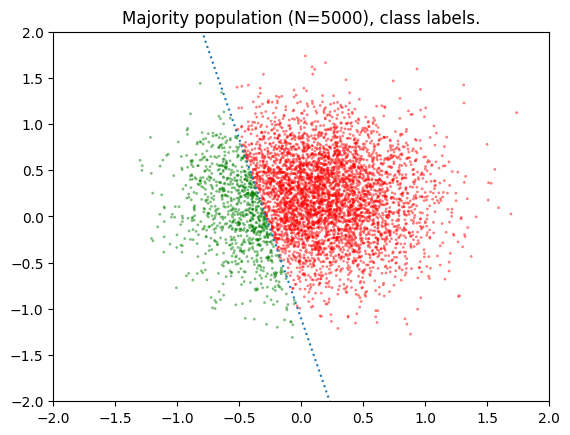

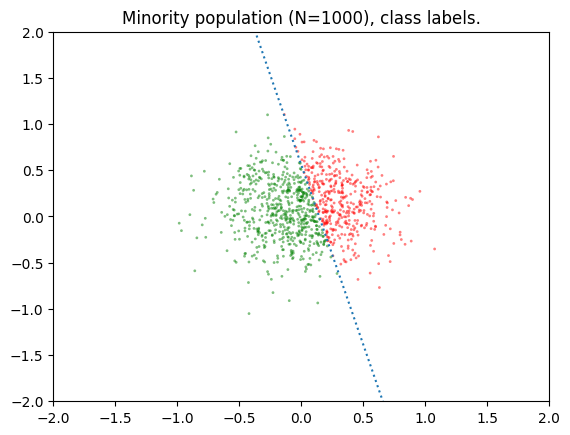

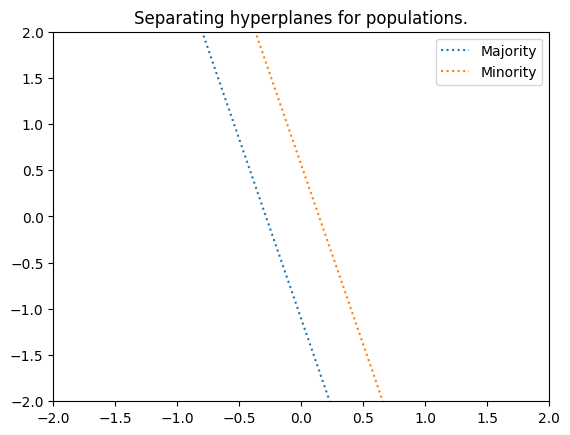

In [3]:
seed = 42069
key = random.PRNGKey(seed)

config_1 = {
    'label': 'Majority',
    'size': 5000,
    'input_mean': (0.1, 0.2),
    'input_covariance': ((0.2, 0.0), (0.0, 0.2)),
    'weights': jnp.array((3.5, 0.9, 1.0)),
    'noise_variance': 0.,
}
config_2 = {
    'label': 'Minority',
    'size': 1000,
    'input_mean': (0.05, 0.1),
    'input_covariance': ((0.1, 0.0), (0.0, 0.1)),
    'weights': jnp.array((3.5, 0.9, -0.5)),
    'noise_variance': 0.,
}

key, subkey = random.split(key)
inputs_1, labels_1 = cdg.generate_samples(subkey, **config_1)

key, subkey = random.split(key)
inputs_2, labels_2 = cdg.generate_samples(subkey, **config_2)


def plot_boundary_line(config, plot_extent):
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    plt.plot(domain, boundary_line(domain, config['weights']), linestyle=':', label=config['label'])

def plot_population(inputs, labels, config, plot_extent):
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    plt.scatter(
        inputs[:, 0],
        inputs[:, 1],
        alpha=0.5,
        linewidths=0,
        s=4,
        c=['red' if y else 'green' for y in labels],
    )
    plot_boundary_line(config, plot_extent)

    plt.title(f'{config["label"]} population (N={config["size"]}), class labels.')
    plt.xlim((-plot_extent, plot_extent))
    plt.ylim((-plot_extent, plot_extent))


def plot_population_comparison(population_configs, plot_extent):
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    for config in population_configs:
        plot_boundary_line(config, plot_extent)

    plt.title('Separating hyperplanes for populations.')
    plt.xlim((-plot_extent, plot_extent))
    plt.ylim((-plot_extent, plot_extent))
    plt.legend()

plot_population(inputs_1, labels_1, config_1, 2)
plt.show()

plot_population(inputs_2, labels_2, config_2, 2)
plt.show()

plot_population_comparison([config_1, config_2], 2)
plt.show()

In [4]:
inputs = jnp.concatenate((inputs_1, inputs_2))
labels = jnp.concatenate((labels_1, labels_2))

cvar_alphas = jnp.logspace(-1, 0, 5)
batch_sizes = [256, 512]

steps = 5e5
step_size = 0.000001
init_weights = jnp.array((0.1, 0.1, 0.1)).reshape((3, 1))

results = {}
for batch_size in batch_sizes:
    print(f'Sweeping batch size {batch_size}...')

    results[batch_size] = {}
    results[batch_size]['averaged_weights'] = []
    results[batch_size]['loss_trajectories'] = []
    for cvar_alpha in cvar_alphas:
        weights, loss_trajectory = dro.train_averaged_dro(
            key,
            inputs,
            labels,
            init_weights,
            dg.linear_outputs,
            dro.squared_err_loss,
            step_size,
            int(batch_size),
            float(cvar_alpha),
            steps,
        )
        results[batch_size]['averaged_weights'].append(weights)
        results[batch_size]['loss_trajectories'].append(loss_trajectory)
        print(f'⍺={cvar_alpha:0.2f} ✅ ', end='')
    print('')

for batch_size in results.keys():
    for cvar_alpha, losses in zip(cvar_alphas, results[batch_size]['loss_trajectories']):
        plt.plot(losses, alpha=0.5, label=f'$\\alpha={cvar_alpha:0.3f}$', color=plt.cm.cividis(cvar_alpha))
    plt.title(f'Weighted training step loss, batch size $n={batch_size}$')
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.semilogy()
    plt.savefig(f'plots/classification_loss_vs_steps_{batch_size}.png')
    plt.clf()

Sweeping batch size 256...


KeyboardInterrupt: 

In [ ]:
def plot_loss_trajectory_sweep(sweep_parameters, loss_trajectories, sweep_parameter_name):
    # TODO: pass in label, color mapping as lambda
    for sweep_parameter, losses in zip(sweep_parameters, loss_trajectories):
        plt.plot(losses, alpha=0.5, label=f'${sweep_parameter_name}={sweep_parameter:0.3f}$', color=plt.cm.cividis(sweep_parameter))

for batch_size in results.keys():
    plot_loss_trajectory_sweep(cvar_alphas, results[batch_size]['loss_trajectories'], '\\alpha')
    plt.title(f'Weighted training step loss, batch size $n={batch_size}$')
    plt.legend()
    plt.semilogy()
    plt.show()

In [ ]:
def plot_model_sweep(sweep_parameters, learned_weights, sweep_parameter_name, plot_extent):
    # TODO: pass in label, color mapping as lambda
    domain = jnp.linspace(-plot_extent, plot_extent, 100)

    for sweep_parameter, weights in zip(sweep_parameters, learned_weights):
        plt.plot(
            domain,
            boundary_line(domain, weights),
            alpha=0.7,
            label=f'${sweep_parameter_name}={sweep_parameter:0.4f}$',
            color=plt.cm.viridis((4 + jnp.log(sweep_parameter) / jnp.log(10)) / 4),
            linewidth=1,
        )

for batch_size in results.keys():
    plot_extent = 2

    plot_population_comparison([config_1, config_2], plot_extent)

    plot_model_sweep(
        cvar_alphas,
        results[batch_size]['averaged_weights'],
        '\\alpha',
        plot_extent,
    )
    plt.title(f'Learned model, batch size $n={batch_size}$')
    plt.legend()
    plt.show()